# A model of imperfect understanding of income process

This notebook experiments multiple dimensions via which agents misspecify the model of income leading to following empirical patterns of subjective income risk

- Higher realizations corresponding to lower perceived risks 
- Older age corresponds to lower uncertainty 
- Cohort-specific uncertainty depending on the past realization of the income dispersion of the group 
- Certain kind of asymmetry in the effect of realization of shocks, i.e. positive shocks brings about lower uncertainty and higher reduces the uncerainty. 
- Interplay between income realizations and uncertainty, i.e. extrapolative from first moment to the second 

### A generic model of learning  


\begin{eqnarray}
y_{i,c,t} = \rho y_{i,c,t-1} + \epsilon_{i,c,t}
\end{eqnarray}

- persistence parameter is the same across cohort and inviduals. It is known by the modeler but not perfectly understood by the agents 
- the income shock is purely i.i.d., independent across individuals and time, namely 

\begin{eqnarray}
E(\epsilon_{i,c,t},\epsilon_{j,c,t}) = 0 \quad \forall i \neq j
\end{eqnarray}

and 

\begin{eqnarray}
E(\epsilon_{i,c,t},\epsilon_{i,c,t+k}) = 0 \quad \forall k >0
\end{eqnarray}

- individual $i$ learns about the income process by "running" a regression of the above model using a limited sample of experienced income realizations of herself from $0$ to $t$ and a subsample of people from the same cohort or the population. 

- when learning, however, the agent has no perfect understanding of the shock is i.i.d., instead, she thinks that her shock at time $t$ is either serially correlated or cross-sectionally correlated. The former represents the scenario where the agent thinks a purely one-period shock is actually more persistent than the truth. The later represents a scenario in which the agent thinks an entirely idiosyncratic shock is actually an aggregate one affecting all in the cohort. What's potentially interesting is that we could allow people's mis-interpretation to depend on the sign of the realized shock. The asymmetry of cross-sectional correlation bias could be driven by  people's asymmetric behavior attributing a bad luck to external causes while a good one to internal causes. The misinterpretation of time-serial correlation hinges on the people's degree of subjective optimism. A bad (good) luck will be interpreted as a more persistent (transitory) one by a pessimist but a transitory (persistent) one by an optimist. These mechanisms interact each other. The following

More formally, this implies the following by denoting $E_{i,t}$ as people's subjective perception of the model.

Serially correlation means 

\begin{eqnarray}
E_{i,t}(\epsilon_{i,c,t},\epsilon_{i,c,t+k}) \neq 0 \quad \forall \quad k 
\end{eqnarray}

Cross-sectional correlation means

\begin{eqnarray}
E_{i,t}(\epsilon_{i,c,t},\epsilon_{j,c,t+k}) \neq 0 \quad \forall i \neq j \text{ and } i, j \in c 
\end{eqnarray}

It is worth pointing out that so far, we have not introduced any model mis-specification that induces bias of the estimate of the persistence parameter $\rho$. But there is no any practical hurdle of doing that. For instance, we could allow the regressors to be subject to some measurement errors. Also, we could allow the past observations to enter the learning in a diminshing weight to capture the idea of memory decay, i.e. people overweight recent memories. In the baseline model, I omit these extensions in order to focus on the implication of the model mis-specification on the uncertainty about the parameter. 

In general, the variance of the coefficient estimate that takes into account the serial or cross-sectional correlation is higher than the one corresponding to the i.i.d. assumption. This will endogenously generate difference in individual's uncertainty about their future income prediction.  

In [51]:
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
import numpy.linalg as lg

In [113]:
class ARProcess:
    def __init__(self,
                 ar_paras = np.array([0.97,0.1]),
                 N = 60):
        self.ar_paras = ar_paras
        self.rho = ar_paras[0]
        self.sigma = ar_paras[1]
        self.N = N 
        self.k = 1
        self.burn = 0.1
        self.n_sim = 60
        self.shock_type = 'iid'
        self.shock_type_perceived = 'iid'
             
# simulate individual time series and cross-sectional data 

    def Simulate(self):
        ar1 = self.ar_paras
        rho,sigma = ar1
        ma1 = np.array([1])
        N_burn = int(self.burn*self.N)
        N_long = self.N + N_burn
        simulated_data = np.empty(N_long)
        simulated_data[0] = 0.01
        if self.shock_type =='iid':
            shocks = sigma*np.random.randn(N_long)
        for i in range(N_long-1):
            simulated_data[i+1] = rho*simulated_data[i] + shocks[i+1]
        #AR_object1 = ArmaProcess(ar1,ma1)
        #simulated_data = AR_object1.generate_sample(nsample = self.N)
        self.simulated = simulated_data[N_burn:]
        return self.simulated 
    
    def SimulatePop(self):
        self.simulated_pop = np.empty([self.n_sim,self.N])
        for i in range(self.n_sim):
            self.simulated_pop[i,:] = self.Simulate()
        return self.simulated_pop
    
## benchmark model consistent with the true model 
    
    def LearnPara(self,
                  obs = 'all'):  ## obs = ['all','experience','cohort']
        if obs == 'all':
            sample = self.simulated_pop
        Y = np.asmatrix(sample[:,1:].flatten()).T
        X = np.asmatrix(sample[:,:-1].flatten()).T
        nobs = len(Y)
        model = sm.OLS(Y,X)
        rs = model.fit()
        #print(rs.summary())
        coeffs_est = rs.params
        self.rs_correct = rs
        self.errs = rs.resid.reshape(self.n_sim,self.N-1) ## residuals matrix 
        if self.shock_type_perceived == 'iid':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D = np.eye(nobs)*self.sigma**2
            self.D_est = np.eye(nobs)*self.sigma2_est
            xx = np.dot(X.T,X)
            ## regression coeffs 
            #coef_var_est0 = rs.bse**2  # using statsmodel package 
            coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
            #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
            #                                     X.T),
            #                                     self.D_est),
            #                              X),
            #                       lg.inv(xx)
            #                      )) ## by general formula 
            self.coef_var_est = coef_var_est1
            
        if self.shock_type_perceived == 'cluster':
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[:,j]*self.errs[:,j])),
                                       lg.inv(np.matrix(np.sum(sample[:,j]*self.errs[:,j]
                                                              )
                                                       )
                                             )
                                      ) for j in range(self.N-1)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*self.N/(self.N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            self.coef_var_est = coef_var_est2
            
        if self.shock_type_perceived == 'serial_correlate':
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:])),
                                       lg.inv(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:]
                                                              )
                                                       )
                                             )
                                      ) for i in range(self.n_sim)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*self.N/(self.N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            self.coef_var_est = coef_var_est2
        
        ## common estimate 
        self.paras_learned_correct = coeffs_est
        
        ## forecast 
        self.var_predict_chg = self.sigma**2
        self.var_predict_chg_est = self.sigma2_est + sample[:,-1]**2*self.coef_var_est 
        # n_sim individual-specific var
        
        #self.msfe = self.sigma**2 + 
        #self.msfe_est = self.sigma2_est + 
        
        return self.paras_learned_correct,self.coef_var_est

In [114]:
## initialize an instance 

one = ARProcess()
simulated_data1 = one.Simulate()

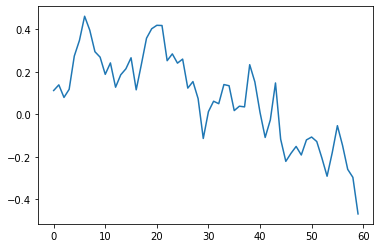

In [115]:
## simulate ar1 data 

plt.subplot(1,1,1)
plt.plot(simulated_data1)

Text(0.5, 1.0, 'Time series distribution')

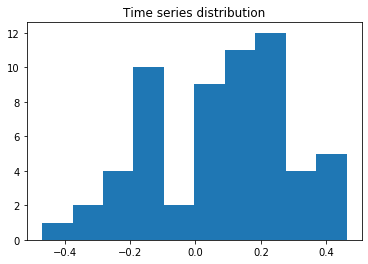

In [116]:
dist = plt.hist(simulated_data1)
plt.title('Time series distribution')

In [117]:
one.n_sim = 30
simulated_data_pop = one.SimulatePop()

Text(0.5, 1.0, 'Unconditional distribution')

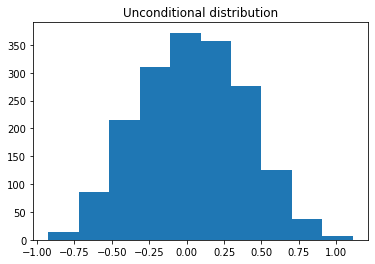

In [118]:
dist_pop = plt.hist(simulated_data_pop.flatten())
plt.title('Unconditional distribution')

In [119]:
one.LearnPara()

(array([0.96250402]), array([[4.49494788e-05]]))

In [120]:
one.var_predict_chg

0.010000000000000002

In [121]:
np.mean(one.var_predict_chg_est)

0.009756369228846238

In [122]:
one.shock_type_perceived = 'cluster'
one.LearnPara()

(array([0.96250402]), array([[0.27659164]]))

In [123]:
np.mean(one.var_predict_chg_est)

0.04448884739606466

In [124]:
one.shock_type_perceived = 'serial_correlate'
one.LearnPara()

(array([0.96250402]), array([[0.14063982]]))